# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

**Dataset** : https://github.com/sekilab/RoadDamageDetector

**YOLOv5**: https://github.com/ultralytics/yolov5

## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

For this stage, DataChics have chosen the challenge **"(Literally) Paving the way towards safer cities"**. The aim of this project was to address the 11th United Nations Goal: Make cities and human settlements inclusive, safe, resilient, and sustainable. It directly targets goal 11.2 by improving road safety and contributing to an increase in cycling rates which is one of the most affordable and healthy ways of transport.  In this way, we are empowering those economically vulnerable with no means to afford a car while taken care of the environment.

The idea is to train a model that is able to detect and identify on images different types of road deffects so that we may be able to identify zones on Lisbon that need to be repaired in order to make them as safe as possible for cyclists. 

## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

# **0. Imports**

In [ ]:
#Installing Kepler
!pip install keplergl

     |████████████████████████████████| 7.9MB 5.2MB/s 
     |████████████████████████████████| 1.0MB 35.2MB/s 
     |████████████████████████████████| 15.3MB 249kB/s 
     |████████████████████████████████| 6.5MB 38.1MB/s 
     |████████████████████████████████| 92kB 10.3MB/s 
  Created wheel for keplergl: filename=keplergl-0.2.2-py2.py3-none-any.whl size=15942747 sha256=bde84cbe6a1dd1b518bdcf81499330f8e462d90ebcd3e4aadf14eabc42efbe7b
  Stored in directory: /root/.cache/pip/wheels/0e/78/c4/04ea0dbf6447ad708393751cd6ea453fb682f4c1c734f2247b
Successfully built keplergl
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0


In [ ]:
#Instaling pydeck
!pip install pydeck

     |████████████████████████████████| 4.2MB 5.2MB/s 
     |████████████████████████████████| 122kB 41.0MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.5 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [ ]:
#Installing Gmaps
!pip install gmaps


     |████████████████████████████████| 1.1MB 6.7MB/s 
  Created wheel for gmaps: filename=gmaps-0.9.0-py2.py3-none-any.whl size=2076097 sha256=3b9e701d161dfba8ae84a60c955e3ccbb04812ae7fc9cf73385aac813bfa0b45
  Stored in directory: /root/.cache/pip/wheels/33/eb/41/5302168c36fc8ce8f48143bb58fde1015d5bc0c62bc3ddbb38
Successfully built gmaps


In [ ]:
#Importing packages
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import pandas as pd
import numpy as np 
import gmaps 
import gmaps.datasets 
import matplotlib.pyplot as plt
import plotly.express as px
from keplergl import KeplerGl
import pydeck as pdk
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. Pre-processing**

We felt the potholes dataset from Roboflow was inssuficient to predict pavemente quality in Lisbon since there are more possible deffects on the roads than just potholes. For this reason, we have downloadaded another dataset (link can fe found on previous section "External Links and sources"). In this new dataset there are up to 4 different road defects:
- D00 --> Longitudinal crack
- D10 --> Transverse crack
- D20 --> Alligator crack
- D40 --> Pothole

This section is dedicated to the pre-processing of this dataset in order to prepare be able to do transfer learning and train with YOLOv5.

### **Conversion of annotations**
The chosen dataset has images with annotated road defects divided by the countries where said images were taken. The countries are the following ones:
- Japan
- Czech Republic
- India

There were some problems with the annotations from the last two, so from now on only the Japan images and annotations will be used.


As a first step we convert the annotations from this dataset, which are in Pascal VOC format, into Yolo format, which needs the annotations in the following form:
- `<object-class> <x> <y> <width> <height>`



In [ ]:
%cd '/content/drive/MyDrive/WDL/Stage 3/Challenge 2/test1/test1/Japan/annotations/xmls/'

/content/drive/.shortcut-targets-by-id/1NpjYtMLdpHBStbDz7sLtHFEfGhrIuw_d/Stage 3/Challenge 2/test1/test1/Japan/annotations/xmls


In [ ]:
train_Japan='/content/drive/MyDrive/WDL/Stage 3/Challenge 2/train/train/Japan/annotations/xmls/'
dirs = [train_Japan]
classes = ['D00','D10','D20', 'D40']

In [ ]:
def getImagesInDir(dir_path):
  image_list = []
  for filename in glob.glob(dir_path + '*.xml'):
    image_list.append(filename)
  return image_list

In [ ]:
def convert(size, box):
  dw = 1./(size[0])
  dh = 1./(size[1])
  x = (box[0] + box[1])/2.0 - 1
  y = (box[2] + box[3])/2.0 - 1
  w = box[1] - box[0]
  h = box[3] - box[2]
  x = x*dw
  w = w*dw
  y = y*dh
  h = h*dh
  return (x,y,w,h)


In [ ]:
def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

 

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

 

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text 
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
        
    return(size)

In [ ]:
cwd = getcwd()


for dir_path in dirs:
    #full_dir_path = cwd + '/' + dir_path 
    full_dir_path = dir_path 
    output_path =os.path.split(full_dir_path)[0]
    output_path = output_path +'/yolo/'


    if not os.path.exists(output_path):
        os.makedirs(output_path)


    image_paths = getImagesInDir(full_dir_path)
    list_file = open(full_dir_path + '.txt', 'w')


    for image_path in image_paths:
        list_file.write(image_path + '\n')
        try:
          convert_annotation(full_dir_path, output_path, image_path)
        except:
          pass
    list_file.close()


    print("Finished processing: " + dir_path)

Finished processing: /content/drive/MyDrive/WDL/Stage 3/Challenge 2/test1/test1/Japan/annotations/xmls/


After this pre-processing, inside the Japan xml annotations we have another folder (named yolo) containing the annotations in yolo format. This folder (yolo) is renamed to labels and the annotations are put in the same level as the images so that we have the following folder schema:

- Japan
    - images
    - annotations (in xml format)
    - labels (in yolo format)


We take out of the Japan folder the annotations folder as it is no longer needed.

### **Split dataset: train-validation-test**
Since this dataset contains only train and validation subsets, we split train into two different datasets in order to have train, validation and test datasets.

The function used spits both the images and the labels into train and validation so that they have the following schema:

output
- train
    - images
    - labels

- val
    - images
    - labels


In [ ]:
!pip3 install split-folders tqdm

In [ ]:
%cd /content/drive/MyDrive/WDL/Stage 3/Challenge 2/train/train/

/content/drive/.shortcut-targets-by-id/1NpjYtMLdpHBStbDz7sLtHFEfGhrIuw_d/Stage 3/Challenge 2/train/train


In [ ]:
!pip3 install split-folders tqdm
import splitfolders
import os

folder = os.getcwd()
splitfolders.ratio('Japan', output="output", seed=2222, ratio=(.8, .2))


Streaming output truncated to the last 5000 lines.
Copying files: 13907 files [53:16,  4.75 files/s]
Copying files: 13909 files [53:16,  4.73 files/s]
Copying files: 13911 files [53:16,  5.54 files/s]
Copying files: 13912 files [53:17,  5.03 files/s]
Copying files: 13913 files [53:17,  4.71 files/s]
Copying files: 13914 files [53:17,  4.66 files/s]
Copying files: 13916 files [53:17,  5.52 files/s]
Copying files: 13917 files [53:17,  5.05 files/s]
Copying files: 13918 files [53:18,  4.71 files/s]
Copying files: 13919 files [53:18,  4.68 files/s]
Copying files: 13921 files [53:18,  5.22 files/s]
Copying files: 13922 files [53:18,  4.88 files/s]
Copying files: 13924 files [53:19,  5.53 files/s]
Copying files: 13925 files [53:19,  4.94 files/s]
Copying files: 13926 files [53:19,  4.01 files/s]
Copying files: 13928 files [53:20,  4.54 files/s]
Copying files: 13929 files [53:20,  4.77 files/s]
Copying files: 13930 files [53:20,  4.63 files/s]
Copying files: 13931 files [53:20,  4.34 files/s]

# **2.YOLOv5**

YOLOv5 already has an implementation in Pytorch. However, this implementation allows for fewer tuning options so Data Chics have opted to clone the repository and work with the original .py files. This allows us to have more control of what it can be done and fine tune our model.

As a first step, we clone the repository containing YOLOv5 and install dependencies.

In [ ]:
%cd /content/drive/MyDrive/WDL/Stage 3/Challenge 2/yolov5_new

/content/drive/.shortcut-targets-by-id/1NpjYtMLdpHBStbDz7sLtHFEfGhrIuw_d/Stage 3/Challenge 2/yolov5_new


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 6184, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 6184 (delta 126), reused 145 (delta 89), pack-reused 5980
Receiving objects: 100% (6184/6184), 8.73 MiB | 4.48 MiB/s, done.
Resolving deltas: 100% (4220/4220), done.
/content/drive/.shortcut-targets-by-id/1NpjYtMLdpHBStbDz7sLtHFEfGhrIuw_d/Stage 3/Challenge 2/yolov5
     |████████████████████████████████| 645kB 6.5MB/s 


As we clone the repository in our shared drive there is no need to clone it every time that we run the notebook. After cloning, we only need to change to its directory and install dependendencies as shown below.

In [ ]:
#No hace falta clonar el repo cada vez, pero sí intalar las dependencias
%cd /content/drive/MyDrive/WDL/Stage 3/Challenge 2/yolov5_new
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

/content/drive/.shortcut-targets-by-id/1NpjYtMLdpHBStbDz7sLtHFEfGhrIuw_d/Stage 3/Challenge 2
/content/drive/.shortcut-targets-by-id/1NpjYtMLdpHBStbDz7sLtHFEfGhrIuw_d/Stage 3/Challenge 2/yolov5
     |████████████████████████████████| 645kB 8.5MB/s 


## **Formating**
Now that we have the annotations in the correct form we need to have a specific folder schema (the one Yolo expects to have). The folder schema is the following:

YOLOV5

Dataset
  - Train
      - Images
      - Labels

  - Validation
      - Images
      - Labels

  - Test
      - Images
      - Labels

Our images from Japan (train and val splits are in a folder named outout) already have this schema, we only need to move the folder containing them (output) inside the yolov5 repository.

After, in order to do transfer learning and train a custom model, we need to create a  .yaml file that has information about configuration (number of classes, name of the classes, routes to the images/labels...). The file is configured as follows:

```
train: /content/drive/MyDrive/WDL/yolov5_new/yolov5/output/train
val: /content/drive/MyDrive/WDL/yolov5_new/yolov5/output/val
nc: 4 
names: ['D00','D10','D20', 'D40']
```
This file location should be inside the YOLOv5 cloned repository.

## **Model election**

YOLOv5 has 4 different models:
- YOLOv5s
- YOLOv5m
- YOLOv5l
- YOLOv5x

The difference between them is the number of parameters calculated. As a rule of thumb, the minimum number of parameters needed for a model to work comes from the following calculation:
```
number of images * 10 = number of  parameters 
```
In this case, we need roughly 100 000 parameters. The model that is closest to this number is that of YOLOv5s.  Knowing the model used we need to change its .yaml file because it is of the following form:

```
# parameters
nc: 100  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32
... 
```

Where we need to change the number of classes to the number of classes that is in our dataset. The yaml file of the yolov5s models ends up like this:
```
# parameters
nc: 4  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32
... 
```
This file needs to be inside the cloned repository too.

**NOTE : Usually, the bigger the model (in terms of parameters), the higher the mAP (mean Average Precision) is. However, the larger the model the longer the training time, which translates into more CO2 emissions. If possible, we will try with a larger model too in order to evaluate if the mAP is sufficently higher as to be worthy of contaminating more and needing a longer execution time.**


## **Actual Training**
Now that the folder schema is in the correct order and yaml files are configured in the right way we can actually train with the following parameters:
- batch size 32
- epochs 100
- starting weights are those from the yolov5s model

In [ ]:
!python train.py --batch 32 --cfg yolov5s_WDL.yaml --weights yolov5s.pt --data defects_WDL.yaml --epochs 100 --project runs/default --name trial_1 --cache-images

/bin/sh: git: command not found
github: Command 'git fetch && git config --get remote.origin.url' returned non-zero exit status 127.
YOLOv5 🚀 2021-5-8 torch 1.8.1+cu102 CPU

Namespace(adam=False, artifact_alias='latest', batch_size=32, bbox_interval=-1, bucket='', cache_images=True, cfg='yolov5s_WDL.yaml', data='defects_WDL.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='trial_1', noautoanchor=False, nosave=False, notest=False, project='runs/default', quad=False, rect=False, resume=False, save_dir='runs/default/trial_18', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=32, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/default', view at http://localhost:6006/
2021-05-08 20:46:48.408027: W tensorflow/stream_exe

Sadly, the model took a lot of computational time and resources (we all had our Google Colab accounts temporarly restricted to GPU use) so we had to train the model on the Oracle VM, whcih didn't have a GPU so the process was even slower.

The model achieves a mAP@.5 of ~0.5, which is not a really accurate result. Given the lack of time we chose ot use the model even if it is not the best so that we can create a valid pipeline, which to be used it will need further training of the model

## **Make Inference on Lisbon Images**

So far we have created a model that detects road defects. The idea is to use this model to make inference on our images from Lisbon to detected defects and plot them with their location so that we may be able to detect safe and non-safe zones for cyclists.

We make inference on them and save the objects detected on a txt file, one per every image, so that we can later put this information on a dataframe. Confidence and iou threshold are lower that they should be because the model is not very precise. We do this even thougt it will detect sometimes wrongly because we want to taste the pipeline.

In [ ]:
%cd /content/drive/MyDrive/WDL/Stage 3/Challenge 2/

/content/drive/.shortcut-targets-by-id/1NpjYtMLdpHBStbDz7sLtHFEfGhrIuw_d/Stage 3/Challenge 2


In [ ]:
#Make inference on Lisbon images and save detected objects in txt per image
!python yolov5_new/yolov5/detect.py --weights yolov5_new/yolov5/runs/default/trial_18/weights/best.pt  --img 640 --conf 0.3 --iou-thres 0.3 --source Competition/Competition/images --save-txt 

Se han truncado las últimas 5000 líneas del flujo de salida.
image 5042/10038 /content/drive/My Drive/WDL/Stage 3/Challenge 2/Competition/Competition/images/image622angle270.jpg: 640x640 Done. (0.439s)
image 5043/10038 /content/drive/My Drive/WDL/Stage 3/Challenge 2/Competition/Competition/images/image622angle90.jpg: 640x640 Done. (0.438s)
image 5044/10038 /content/drive/My Drive/WDL/Stage 3/Challenge 2/Competition/Competition/images/image623.jpg: 640x640 Done. (0.440s)
image 5045/10038 /content/drive/My Drive/WDL/Stage 3/Challenge 2/Competition/Competition/images/image623angle0.jpg: 640x640 Done. (0.467s)
image 5046/10038 /content/drive/My Drive/WDL/Stage 3/Challenge 2/Competition/Competition/images/image623angle180.jpg: 640x640 Done. (0.469s)
image 5047/10038 /content/drive/My Drive/WDL/Stage 3/Challenge 2/Competition/Competition/images/image623angle270.jpg: 640x640 Done. (0.443s)
image 5048/10038 /content/drive/My Drive/WDL/Stage 3/Challenge 2/Competition/Competition/images/image623

Now that we have done object detection on our images (the ones provided of the roads of Lisbon) we want to create a dataframe that has the information about the defects detected on said images. For each Lisbon image there is a new txt file with the objects that our model has detected so we extract said information into a df with the following code:


In [ ]:
import os, glob
import pandas as pd

files = glob.glob("runs/detect/exp2/labels/*") #creates a list of all csv files
data = []

for txt in files:
    frame = pd.read_table(txt, delim_whitespace=True, names=('class','x', 'y', 'width','height'), engine='python')
    frame['filename'] = os.path.basename(txt)
    data.append(frame)

bigframe = pd.concat(data, ignore_index=True)

In [ ]:
bigframe.to_csv('df_inference.csv', index = False, header = True)

In [ ]:
bigframe [1:10]

class         x         y     width    height              filename
1      2  0.400781  0.689844  0.095312  0.064062  image508angle270.txt
2      3  0.059375  0.978125  0.096875  0.040625           image51.txt
3      3  0.727344  0.714844  0.082812  0.035937          image512.txt
4      3  0.957031  0.980469  0.082812  0.035937          image512.txt
5      2  0.686719  0.875000  0.626562  0.246875          image512.txt
6      3  0.660156  0.774219  0.126563  0.079687          image512.txt
7      3  0.638281  0.785156  0.129688  0.120312    image513angle0.txt
8      2  0.878125  0.949219  0.237500  0.095312  image515angle270.txt
9      3  0.058594  0.978125  0.098437  0.040625    image516angle0.txt

We have noticed that there are only 2500 places provided in Lisbon but there are more than 10 000 images due to rotation for image augmentation. We want to join the dataframe that comes from the inference (above df) with the one that will be extracted below with the coordinates per image. Since the names of the inferred images include the angle at which they were rotated, we need to split this name in order to get the name of the image without the angle informatin to make the joi.

In [ ]:
bigframe[['Image','angle']] = bigframe.filename.str.split("angle",expand=True)
bigframe['Image'] = bigframe.Image.str.split(".txt").str[0]

In [ ]:
bigframe

class         x         y  ...              filename     Image    angle
0         2  0.574219  0.856250  ...  image503angle180.txt  image503  180.txt
1         2  0.400781  0.689844  ...  image508angle270.txt  image508  270.txt
2         3  0.059375  0.978125  ...           image51.txt   image51     None
3         3  0.727344  0.714844  ...          image512.txt  image512     None
4         3  0.957031  0.980469  ...          image512.txt  image512     None
...     ...       ...       ...  ...                   ...       ...      ...
2190      2  0.575000  0.745313  ...   image500angle90.txt  image500   90.txt
2191      2  0.079687  0.926562  ...  image501angle180.txt  image501  180.txt
2192      3  0.057813  0.978125  ...          image502.txt  image502     None
2193      2  0.681250  0.845312  ...    image502angle0.txt  image502    0.txt
2194      2  0.211719  0.868750  ...    image503angle0.txt  image503    0.txt

[2195 rows x 8 columns]

In [ ]:
bigframe.to_csv('df_inference.csv', index = False, header = True)

Also, we had a txt file per Lisbon image with the coordinates of the images. We extract that information too and join the two dfs so that now we have detected defects and its localization. The code is similar to the one used before.

In [ ]:
%cd /content/drive/MyDrive/WDL/Stage 3/Challenge 2/

/content/drive/.shortcut-targets-by-id/1NpjYtMLdpHBStbDz7sLtHFEfGhrIuw_d/Stage 3/Challenge 2


In [ ]:
files2 = glob.glob("Competition/Competition/coordinates/*")
data2 = []

for txt in files2:
    frame2 = pd.read_table(txt, delimiter= ";", names=('latitude','longitude'), engine='python')
    frame2['filename'] = os.path.basename(txt)
    data2.append(frame2)

bigframe2 = pd.concat(data2, ignore_index=True)

In [ ]:
bigframe2['latitude'] = bigframe2['latitude'].str[4:]
bigframe2['longitude'] = bigframe2['longitude'].str[3:]
bigframe2['filename'] = bigframe2.filename.str.split(".txt").str[0]

In [ ]:
bigframe2

latitude           longitude      filename
0            38.7538068          -9.1442701  votingImage2
1            38.7607443          -9.1581009  votingImage4
2     38.74792028587157  -9.150743978870837  votingImage5
3     38.77900043495775  -9.157094072444641  votingImage3
4     38.72778421972878  -9.175392935445183  votingImage7
...                 ...                 ...           ...
2495  38.74526600951361   -9.19271143602313      image494
2496  38.74325047793822  -9.157496661608434      image497
2497  38.76555856593171  -9.179047207419808      image496
2498  38.74474374117094  -9.132585218743493      image498
2499  38.73332251857713   -9.18650011095672      image499

[2500 rows x 3 columns]

In [ ]:
bigframe2.to_csv('df_coordinates.csv', index = False, header = True)

In [ ]:
df_coordinates = pd.read_csv('df_coordinates.csv')
df_inference = pd.read_csv('df_inference.csv')

In [ ]:
df_inference.Image.value_counts()

image1051         8
votingImage819    7
image13           7
image182          7
image289          7
                 ..
votingImage119    1
votingImage248    1
image1366         1
votingImage93     1
image641          1
Name: Image, Length: 1218, dtype: int64

Now, we join the two dfs so that we have one big dataframe with all the information needed. There will be a row for every object detected on the same image and only a single row if there was only one or none objects detected.

In [ ]:
#Join
df_total = df_coordinates.merge(df_inference, left_on='filename', right_on='Image', how= 'left')

In [ ]:
df_total #Este  muestra donde había defecto y donde no. Los NaNs son porque en esa imagen no había defecto.

latitude  longitude  ...     Image    angle
0     38.753807  -9.144270  ...       NaN      NaN
1     38.760744  -9.158101  ...       NaN      NaN
2     38.747920  -9.150744  ...       NaN      NaN
3     38.779000  -9.157094  ...       NaN      NaN
4     38.727784  -9.175393  ...       NaN      NaN
...         ...        ...  ...       ...      ...
3472  38.745266  -9.192711  ...       NaN      NaN
3473  38.743250  -9.157497  ...  image497  270.txt
3474  38.765559  -9.179047  ...       NaN      NaN
3475  38.744744  -9.132585  ...       NaN      NaN
3476  38.733323  -9.186500  ...       NaN      NaN

[3477 rows x 11 columns]

In [ ]:
df_total = df_total.drop(['x','y','width','height','angle','filename_y'], axis =1)

In [ ]:
df_total

latitude  longitude    filename_x  class     Image
0     38.753807  -9.144270  votingImage2    NaN       NaN
1     38.760744  -9.158101  votingImage4    NaN       NaN
2     38.747920  -9.150744  votingImage5    NaN       NaN
3     38.779000  -9.157094  votingImage3    NaN       NaN
4     38.727784  -9.175393  votingImage7    NaN       NaN
...         ...        ...           ...    ...       ...
3472  38.745266  -9.192711      image494    NaN       NaN
3473  38.743250  -9.157497      image497    3.0  image497
3474  38.765559  -9.179047      image496    NaN       NaN
3475  38.744744  -9.132585      image498    NaN       NaN
3476  38.733323  -9.186500      image499    NaN       NaN

[3477 rows x 5 columns]

In [ ]:
df_total.to_csv('df_total.csv', index = False, header = True)

# **3. Exploratory assessment of defects**

Now we have a df with all the information needed: coordinates and defects of every image in lisbon. We can count how many defects per image there are and with the coordinates plot in a map so that we have a possible heatmap of safe and non safe locations for cyclists.

### Defect count by category

The plot below shows the total amount of each defect detected on the Lisbon images while also plotting the number of points in the map that have 0 defects.
It can be seen that the most common defect are potholes in the road followed by alligator cracks.
As some of the points have more that one defect we can't compare directly the quantity of defects to the quantity of those points that don't have any. This will be done on the next section "Pareto Analysis"

In [ ]:
#Reading csv of classified defects
defects = (
    "/content/drive/MyDrive/Stage 3/Challenge 2/df_total.csv"  # noqa
)
df_complete = pd.read_csv(defects)
df_complete = df_complete.rename(columns={'latitude': 'lat', 'longitude': 'lng'})

In [ ]:
#Categorizing 'no defects' as class 4
df_complete['class'] = df_complete['class'].fillna(4)

In [ ]:
#Assigning categories to classes and displaying count via barplot
category_count  = df_complete.groupby('class').filename_x.count().reset_index()

category_count.loc[category_count['class'] == 0.0, 'defect_category'] = 'Longitudinal Crack'
category_count.loc[category_count['class'] == 1.0, 'defect_category'] = 'Transverse Crack'
category_count.loc[category_count['class'] == 2.0, 'defect_category'] = 'Aligator Crack'
category_count.loc[category_count['class'] == 3.0, 'defect_category'] = 'Pothole'
category_count.loc[category_count['class'] == 4.0, 'defect_category'] = 'No defects'
import plotly.express as px
fig = px.bar(category_count, x='defect_category', y='filename_x', labels={'defect_category': 'Defect category', 'filename_x':'Defect Count'}, height=400)
#fig.show()


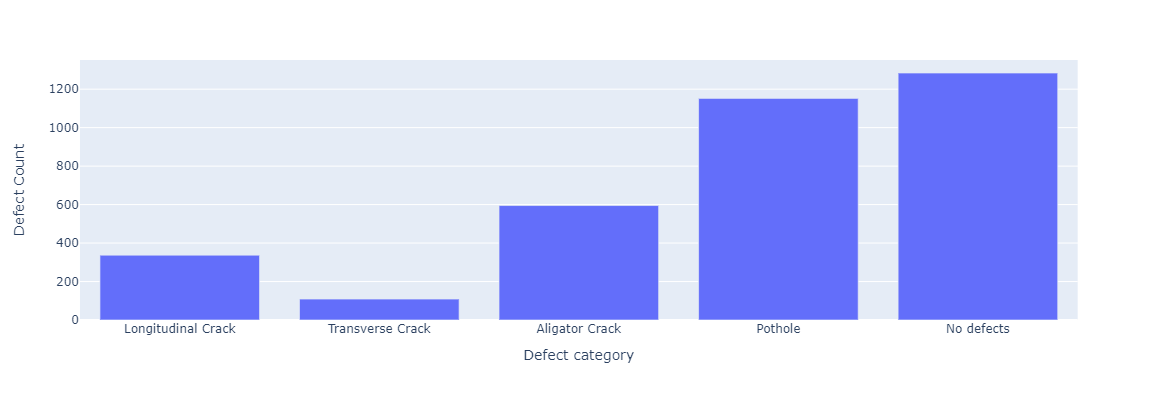

### Scatter plot map by category defect

In [ ]:
#Configure gmaps with api_key 
gmaps.configure(api_key="API_KEY")

In [ ]:
#new dataset without null values (only taking into account images presenting any defect)
df_defects = df_total[df_total['class'].notnull()]
df_defects['class_type'] = np.where(
    df_defects['class'] == 0, "Longitudinal Crack", 
    np.where(df_defects['class'] == 1, "Transverse Crack", 
    np.where(df_defects['class'] == 2, "Aligator Crack", 
    "Pothole")))

Once we get the new dataset with the images that present any defect, it's time to plot the defects distribution along Lisbon roads by category 

In [ ]:
fig = px.scatter_mapbox(df_defects, 
                        lat="latitude", lon="longitude", hover_name="class_type", 
                        hover_data=["class_type"], color = "class_type", 
                        color_discrete_sequence=["#0d0887", "#9c179e", "#ed7953", "#fdca26"], 
                        zoom=10, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

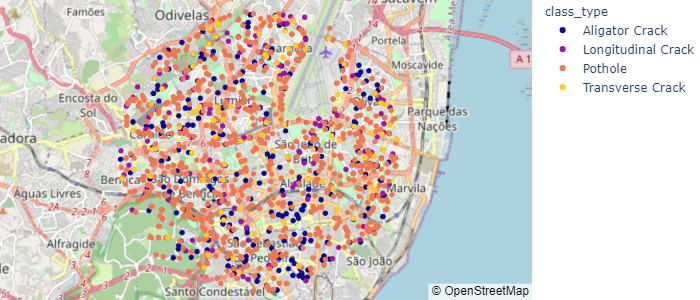

In order to interpret where are the most affected pavement streets in Lsibon, it could be useful to plot a heatmap for each one of the category defects. This will allow us to design an action plan to improve the quality of the road pavement

### Longitudinal Crack Heatmap

In [ ]:
df_0 = df_total[df_total['class'] == 0]
locations_0 = df_0[['latitude','longitude']]
fig_0 = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations_0)
heatmap_layer.gradient = [
    (0, 0, 0, 0), 
    (255, 255, 153), 
    (255, 51, 51),
    (153, 0, 0)
]
heatmap_layer.point_radius = 8
heatmap_layer.max_intensity = 4
fig_0.add_layer(heatmap_layer)
fig_0

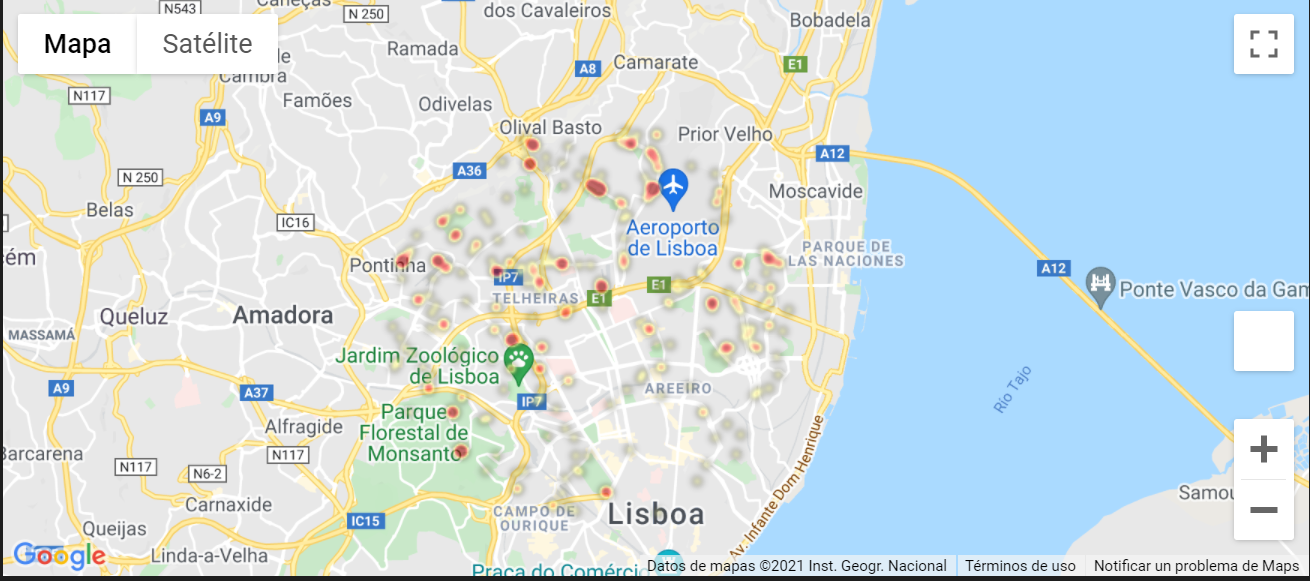

### Transverse Crack Heatmap

In [ ]:
df_1 = df_total[df_total['class'] == 1]
locations_1 = df_1[['latitude','longitude']]
fig_1 = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations_1)
heatmap_layer.gradient = [
    (0, 0, 0, 0), 
    (255, 255, 153), 
    (255, 51, 51),
    (153, 0, 0)
]
heatmap_layer.point_radius = 8
heatmap_layer.max_intensity = 4
fig_1.add_layer(heatmap_layer)
fig_1

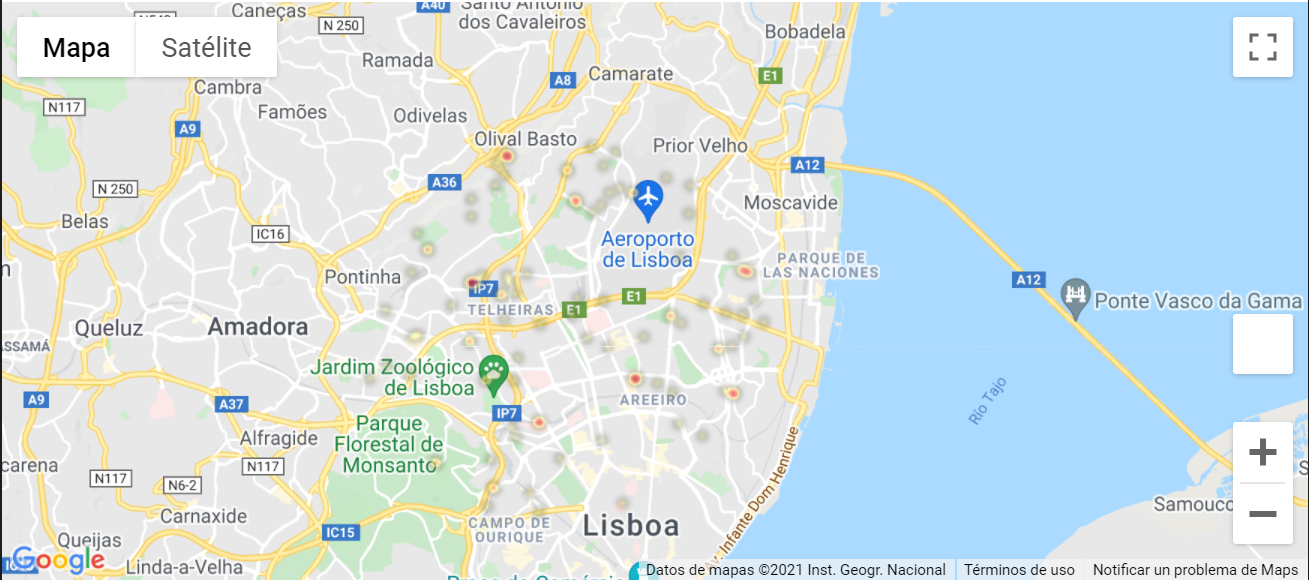

### Aligator Crack Heatmap

In [ ]:
df_2 = df_total[df_total['class'] == 2]
locations_2 = df_2[['latitude','longitude']]
fig_2 = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations_2)
heatmap_layer.gradient = [
    (0, 0, 0, 0), 
    (255, 255, 153), 
    (255, 51, 51),
    (153, 0, 0)
]
heatmap_layer.point_radius = 8
heatmap_layer.max_intensity = 4
fig_2.add_layer(heatmap_layer)
fig_2

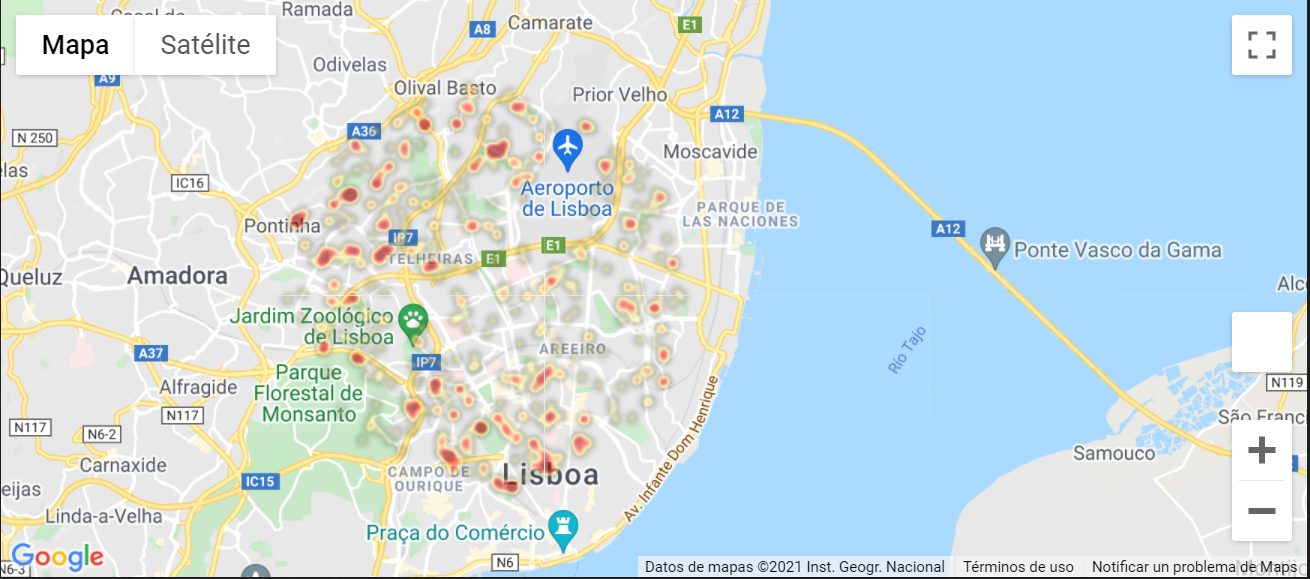

### Potholes Heatmap

In [ ]:
df_3 = df_total[df_total['class'] == 3]
locations_3 = df_3[['latitude','longitude']]
fig_3 = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations_3)
heatmap_layer.gradient = [
    (0, 0, 0, 0), 
    (255, 255, 153), 
    (255, 51, 51),
    (153, 0, 0)
]
heatmap_layer.point_radius = 8
heatmap_layer.max_intensity = 4
fig_3.add_layer(heatmap_layer)
fig_3

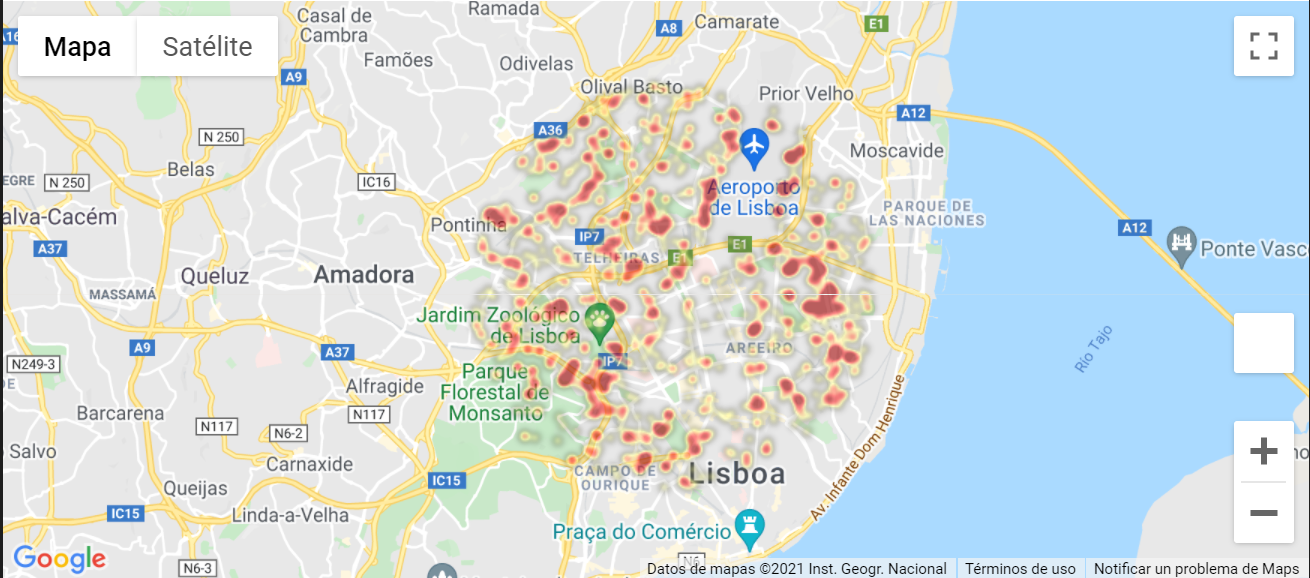

# **4. Pareto analysis - understanding concentration**

In the plot below we want to represent the number of roads that have a quantity of defects equal to the x-axis label. It can be seen that for most points in the map our model hasn't detected any defect.
But also, this is useful for priotizing actions in order to improve the roads pavement quality. As described in the Pareto theorem, we can see that fixing 20% of the streets would had an impact of more than a 50% in the total amount of pavement defects.
This 20% is composed by the all those streets that have more than 2 defects.

In [ ]:
#Grouping defects by unique images
df_gr = df_complete.groupby(['lat', 'lng', 'filename_x']).Image.count().reset_index()
df_gr

lat       lng      filename_x  Image
0     38.719667 -9.155769  votingImage563      1
1     38.719852 -9.150556        image277      3
2     38.719862 -9.148125       image1167      2
3     38.719862 -9.148125        image483      4
4     38.719890 -9.155678   votingImage11      0
...         ...       ...             ...    ...
2495  38.790777 -9.145996  votingImage282      0
2496  38.790789 -9.146144  votingImage122      0
2497  38.790799 -9.148765        image386      0
2498  38.790843 -9.158496  votingImage735      0
2499  38.791043 -9.158254        image325      3

[2500 rows x 4 columns]

In [ ]:
#Total defect distribution
import plotly.express as px

fig = px.histogram(df_gr, x="Image")
fig.show()

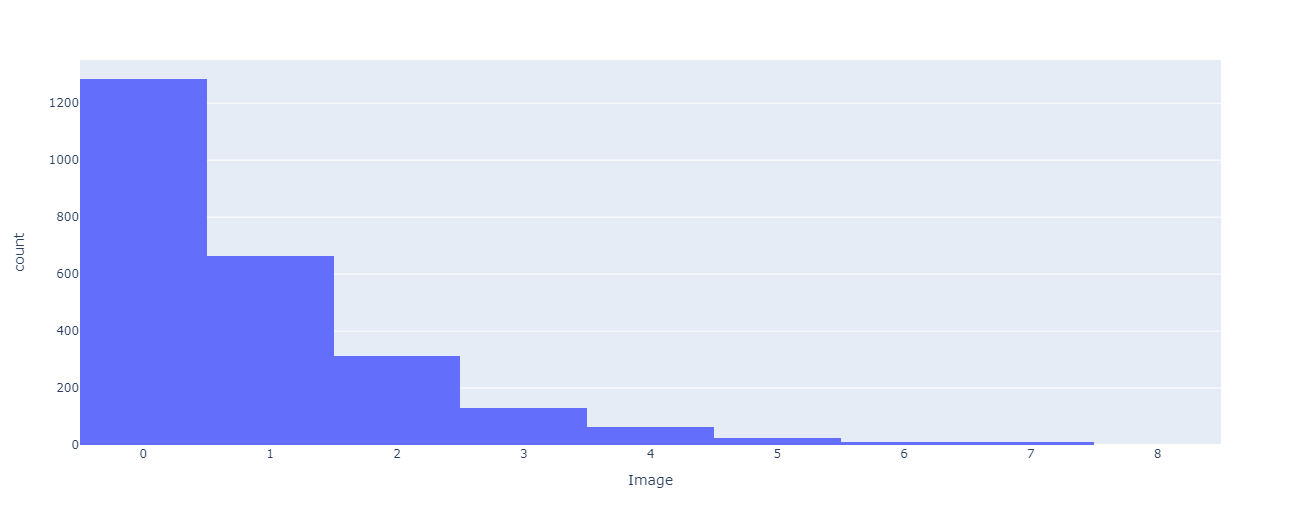

In [ ]:
#Further grouping defects by class
df_gr2 = df_complete.groupby(['lat', 'lng', 'filename_x', 'class']).Image.count().reset_index()

dist0 = df_gr2[df_gr2['class'] == 0.0]
dist1 = df_gr2[df_gr2['class'] == 1.0]
dist2 = df_gr2[df_gr2['class'] == 2.0]
dist3 = df_gr2[df_gr2['class'] == 3.0]
dist4 = df_gr2[df_gr2['class'] == 4.0]

With this plot we want to use the same Pareto Theory, but spliting by the category of the defect. As in the first one, we can observe that:
- For trace0 (defect 00: longitudinal crack) the 46.3% is found on the 24,6% of the points in the map
- For trace1 (defect 10: transverse crack ) the 73.2% is founf on the 86% of the points in the map.
- For trace2 (defect 20: alligator crack) the 44,6% is found on the 26,9% of the points in the map.
- For trace3 (defect 40: porthoes) the 53% is found on the 32.2% of the points in the map.
It means that if we want to make an important effect improving the pavement quality, we should focused on those defects that have a high percentage concentrated in a small qantity of the roads (longitudinal crack, alligator crack, potholes)

In [ ]:
import plotly.graph_objects as go
import numpy as np



fig = go.Figure()
fig.add_trace(go.Histogram(x=dist0['Image']))
fig.add_trace(go.Histogram(x=dist1['Image']))
fig.add_trace(go.Histogram(x=dist2['Image']))
fig.add_trace(go.Histogram(x=dist3['Image']))


# The two histograms are drawn on top of another
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.6)

fig.show()

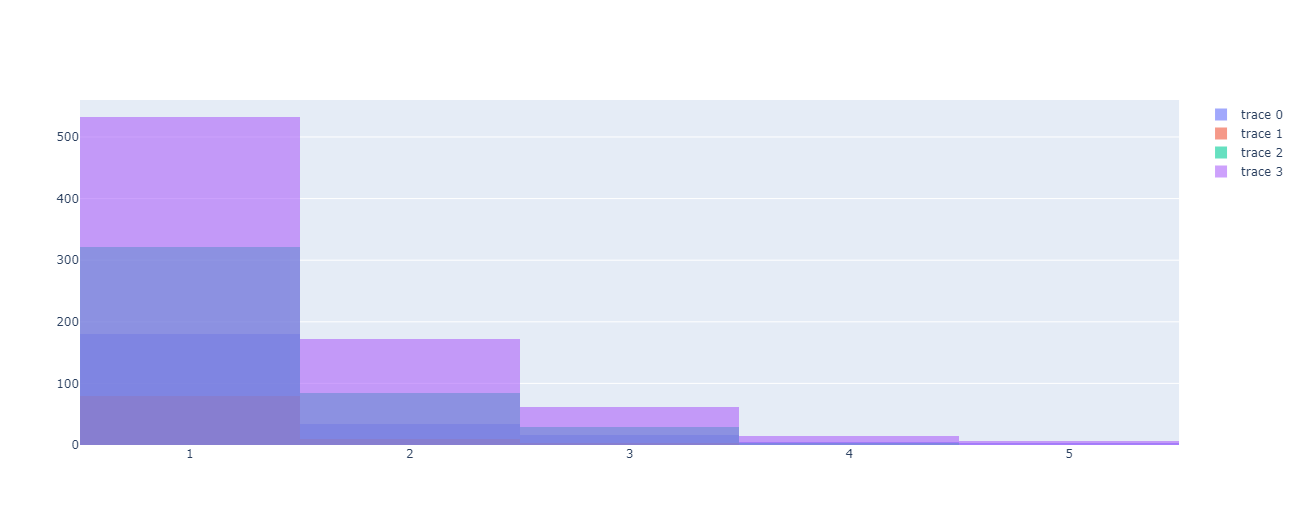

# **5. Solving the problem: pavement maintenance strategy**

We are going to put together the insights discovered into a full-fledged strategy for pavement maintenance. 

First, we will discretize the space into fixed-sized hexagons to facilitate management following the Uber H3 approach.

Next, we will compare the insights from each defect class with the location of such categories to form a strategy.

### Discretizing space via Uber-H3 hexagons

In [ ]:
#Separate the different classes
df = df_complete.dropna()
df_0 = df[df['class'] == 0.0]
df_1 = df[df['class'] == 1.0]
df_2 = df[df['class'] == 2.0]
df_3 = df[df['class'] == 3.0]

lat       lng     filename_x  class          Image
5     38.762006 -9.133959   votingImage6    2.0   votingImage6
45    38.773200 -9.161638  votingImage42    2.0  votingImage42
48    38.762761 -9.132080  votingImage44    2.0  votingImage44
50    38.779448 -9.186619  votingImage48    2.0  votingImage48
57    38.738232 -9.141027  votingImage53    2.0  votingImage53
...         ...       ...            ...    ...            ...
3456  38.719862 -9.148125       image483    2.0       image483
3459  38.727034 -9.158628       image487    2.0       image487
3460  38.766566 -9.165970       image488    2.0       image488
3461  38.766566 -9.165970       image488    2.0       image488
3462  38.757191 -9.164885       image489    2.0       image489

[595 rows x 5 columns]

In [ ]:
#Leveraging coordinates
df = df[['lng', 'lat']]
df_0 = df_0[['lng', 'lat']]
df_1 = df_1[['lng', 'lat']]
df_2 = df_2[['lng', 'lat']]
df_3 = df_3[['lng', 'lat']]

lng        lat
5    -9.133959  38.762006
45   -9.161638  38.773200
48   -9.132080  38.762761
50   -9.186619  38.779448
57   -9.141027  38.738232
...        ...        ...
3456 -9.148125  38.719862
3459 -9.158628  38.727034
3460 -9.165970  38.766566
3461 -9.165970  38.766566
3462 -9.164885  38.757191

[595 rows x 2 columns]

### Longitudinal Crack Strategy

The Longitudinal Crack category is the third most common in terms of defects detected. Also, it is a relatively concentrated category with 46.3% of defects concentrated on 24.6% locations.

We recommend de-prioritizing this defect class. If we were about to repair this category, we recommend following this roadmap:

In [ ]:
#Visualizing pavement defects - Longitudinal Crack
import pydeck as pdk

# Define a layer to display on a map
layer = pdk.Layer(
    "HexagonLayer",
    df_0,
    get_position=["lng", "lat"],
    auto_highlight=True,
    elevation_scale=10,
    pickable=True,
    elevation_range=[0, 1000],
    extruded=True,
    coverage=1,
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-9.199031, latitude=38.748351, zoom=10, min_zoom=5, max_zoom=15, pitch=40.5, bearing=-27.36,
)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html("hexagon_layer.html")
#r.show

<IPython.core.display.Javascript object>

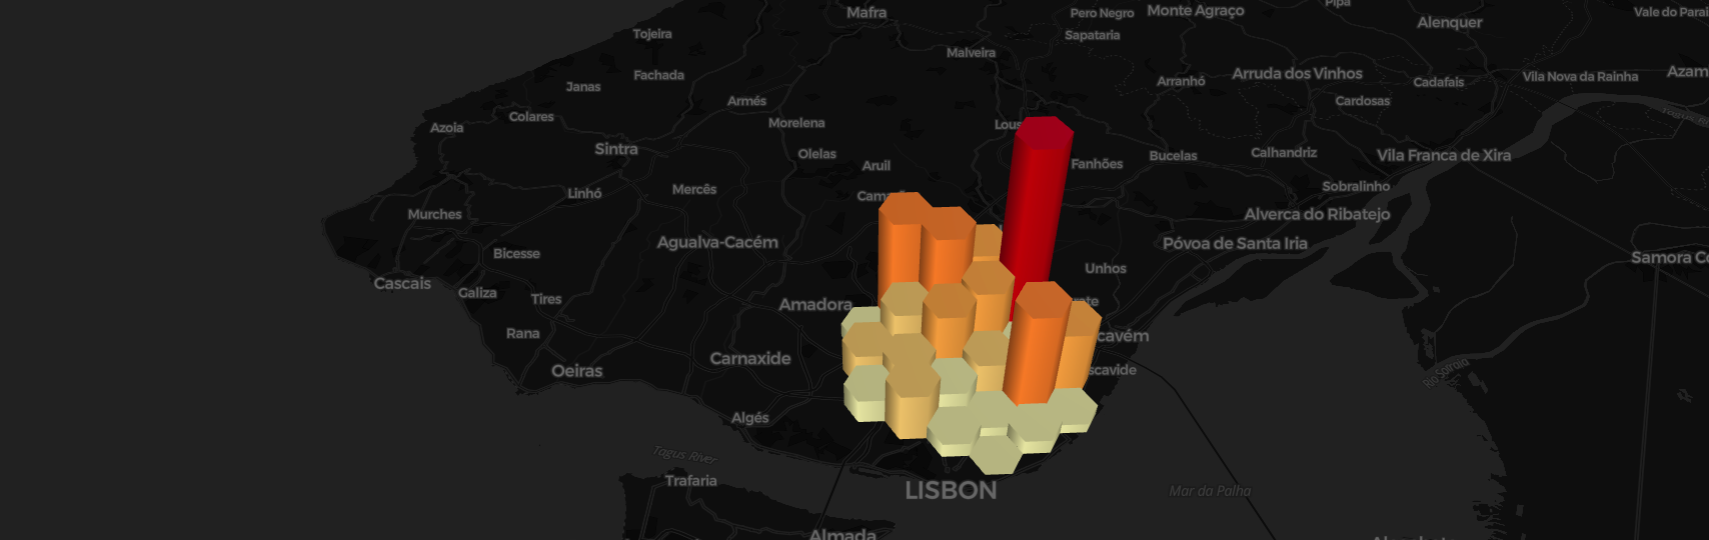

### Transverse Crack Strategy

The Transverse Crack category is the last in terms of defects detected. Also, it this category is completely distributed accross the space. Therefore **we recommend to avoid maintenance for this category in the sort run**.


In [ ]:
#Visualizing pavement defects - class 1
import pydeck as pdk

# Define a layer to display on a map
layer = pdk.Layer(
    "HexagonLayer",
    df_1,
    get_position=["lng", "lat"],
    auto_highlight=True,
    elevation_scale=10,
    pickable=True,
    elevation_range=[0, 1000],
    extruded=True,
    coverage=1,
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-9.199031, latitude=38.748351, zoom=10, min_zoom=5, max_zoom=15, pitch=40.5, bearing=-27.36,
)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html("hexagon_layer.html")
#r.show

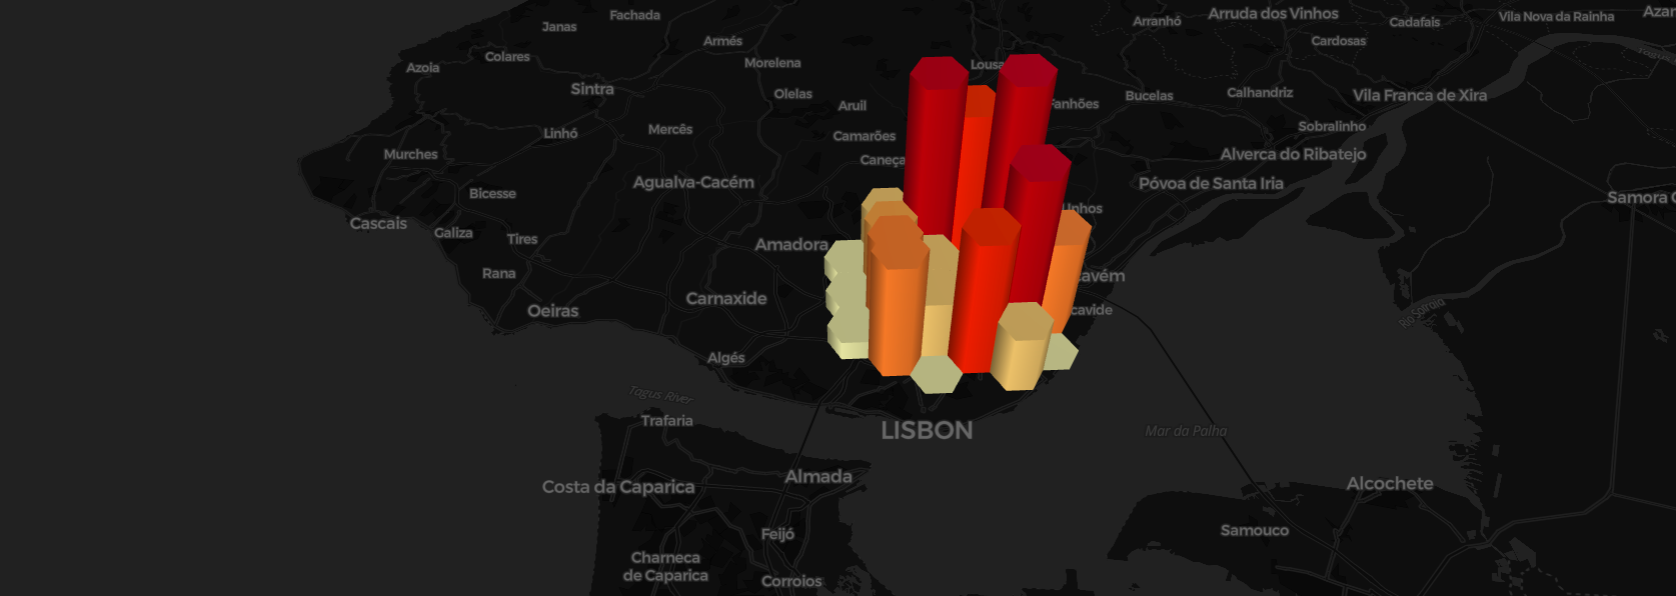

### Aligator Crack Strategy

The Aligator category is the second most common in terms of defects detected. Also, it is a relatively concentrated category with 44,6% of defects concentrated on 26,9% locations. 

If we were to prioritize this category, we recommend following this roadmap:

In [ ]:
#Visualizing pavement defects - class 2
import pydeck as pdk

# Define a layer to display on a map
layer = pdk.Layer(
    "HexagonLayer",
    df_2,
    get_position=["lng", "lat"],
    auto_highlight=True,
    elevation_scale=10,
    pickable=True,
    elevation_range=[0, 1000],
    extruded=True,
    coverage=1,
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-9.199031, latitude=38.748351, zoom=10, min_zoom=5, max_zoom=15, pitch=40.5, bearing=-27.36,
)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html("hexagon_layer.html")
r.show

<IPython.core.display.Javascript object>

<bound method Deck.show of {"initialViewState": {"bearing": -27.36, "latitude": 38.748351, "longitude": -9.199031, "maxZoom": 15, "minZoom": 5, "pitch": 40.5, "zoom": 10}, "layers": [{"@@type": "HexagonLayer", "autoHighlight": true, "coverage": 1, "data": [{"lat": 38.762006105345634, "lng": -9.133958572185012}, {"lat": 38.77319969897995, "lng": -9.161637998554582}, {"lat": 38.7627611795886, "lng": -9.13208006120057}, {"lat": 38.77944796937389, "lng": -9.186619249920856}, {"lat": 38.738232253948865, "lng": -9.141027037948671}, {"lat": 38.7349248, "lng": -9.1176157}, {"lat": 38.76824050000001, "lng": -9.1592875}, {"lat": 38.77805637127954, "lng": -9.14809965125826}, {"lat": 38.762998, "lng": -9.1227131}, {"lat": 38.759681594613134, "lng": -9.165931208650258}, {"lat": 38.759681594613134, "lng": -9.165931208650258}, {"lat": 38.7716381, "lng": -9.1138235}, {"lat": 38.7716381, "lng": -9.1138235}, {"lat": 38.747278171147904, "lng": -9.153870850485065}, {"lat": 38.760053967447426, "lng": -9.16

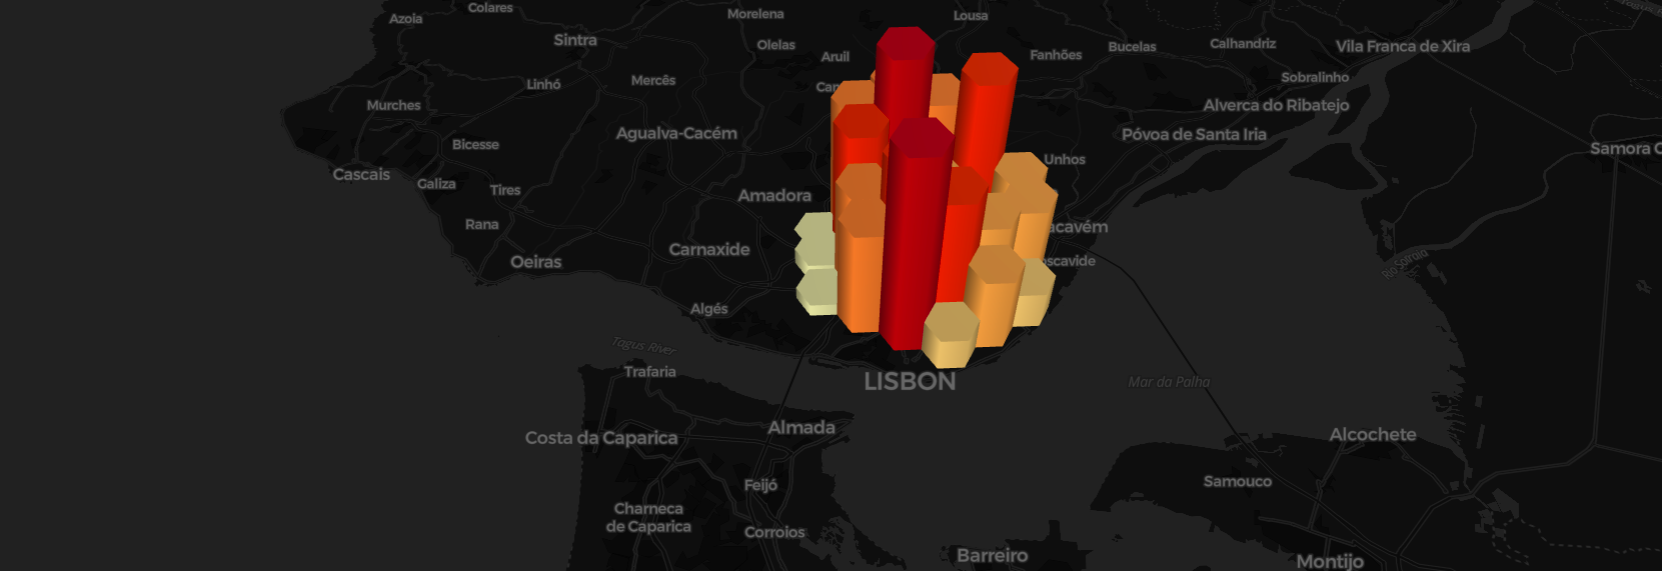

### Pothole Strategy

Pothole defect is the most frequent one. Also, it showcases high-levels of concentration, indicating high potential impact for low levels of effort/cost. Over 53% of defects are found on the 32.2% locations.

We propose the rollout strategy:

In [ ]:
#Visualizing pavement defects - class 3
import pydeck as pdk

# Define a layer to display on a map
layer = pdk.Layer(
    "HexagonLayer",
    df_3,
    get_position=["lng", "lat"],
    auto_highlight=True,
    elevation_scale=10,
    pickable=True,
    elevation_range=[0, 1000],
    extruded=True,
    coverage=1,
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-9.199031, latitude=38.748351, zoom=10, min_zoom=5, max_zoom=15, pitch=40.5, bearing=-27.36,
)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html("hexagon_layer.html")
#r.show

<IPython.core.display.Javascript object>

<bound method Deck.show of {"initialViewState": {"bearing": -27.36, "latitude": 38.748351, "longitude": -9.199031, "maxZoom": 15, "minZoom": 5, "pitch": 40.5, "zoom": 10}, "layers": [{"@@type": "HexagonLayer", "autoHighlight": true, "coverage": 1, "data": [{"lat": 38.75434720550386, "lng": -9.127416163889393}, {"lat": 38.75434720550386, "lng": -9.127416163889393}, {"lat": 38.77291602467256, "lng": -9.119716382503821}, {"lat": 38.7517444948345, "lng": -9.180096527506304}, {"lat": 38.7517444948345, "lng": -9.180096527506304}, {"lat": 38.76555976849321, "lng": -9.156632180894228}, {"lat": 38.73579517292462, "lng": -9.150323376554836}, {"lat": 38.75631669002931, "lng": -9.155189554657426}, {"lat": 38.77404207938617, "lng": -9.116841416397033}, {"lat": 38.77404207938617, "lng": -9.116841416397033}, {"lat": 38.77404207938617, "lng": -9.116841416397033}, {"lat": 38.737860708940225, "lng": -9.17277956544005}, {"lat": 38.737860708940225, "lng": -9.17277956544005}, {"lat": 38.746153936862996, "l

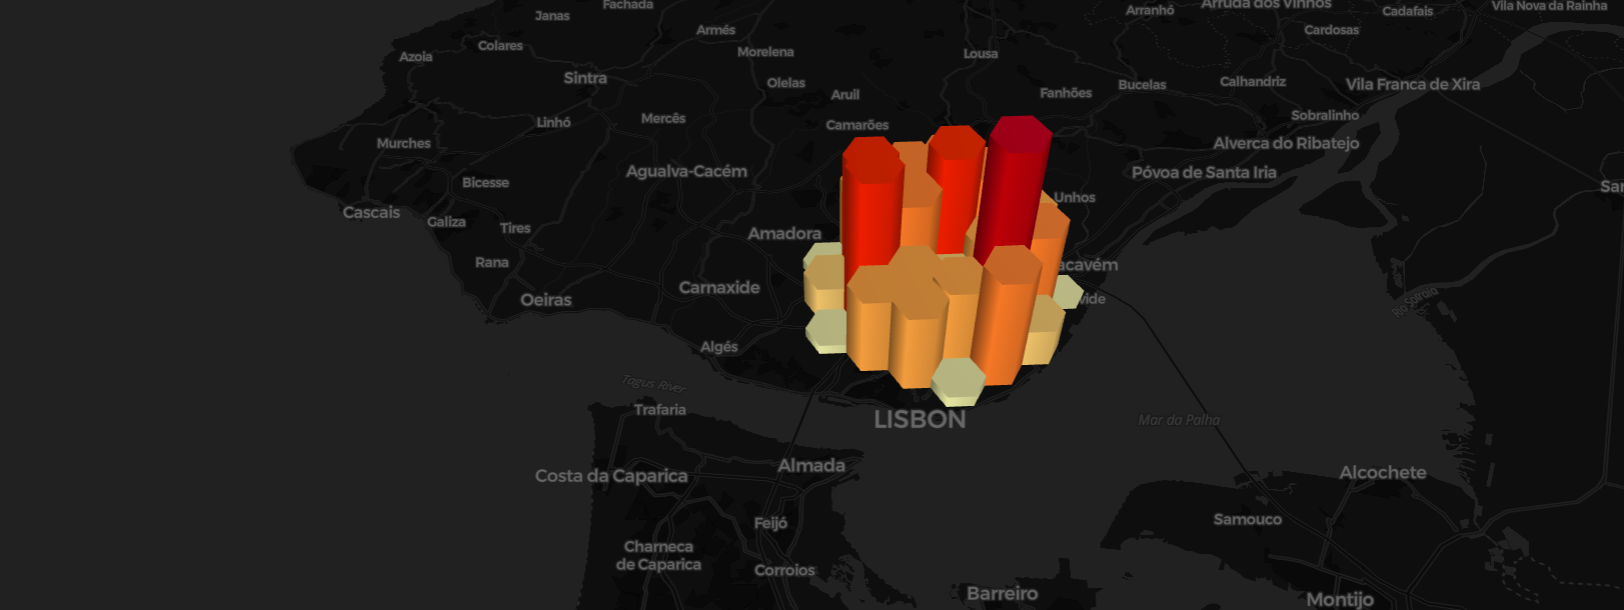

### Consolidated Strategy

To sum up, we recommend focusing on the Pothole category, followed by Aligator Cracks. We based the strategy of the proportion of defects and geographical concentration.

We propose the following maintenance roadmap:

In [ ]:
#Visualizing pavement defects
import pydeck as pdk

# Define a layer to display on a map
layer = pdk.Layer(
    "HexagonLayer",
    df,
    get_position=["lng", "lat"],
    auto_highlight=True,
    elevation_scale=10,
    pickable=True,
    elevation_range=[0, 1000],
    extruded=False,
    coverage=1,
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-9.199031, latitude=38.748351, zoom=10, min_zoom=5, max_zoom=15, pitch=40.5, bearing=-27.36,
)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html("hexagon_layer.html")
r.show

<IPython.core.display.Javascript object>

<bound method Deck.show of {"initialViewState": {"bearing": -27.36, "latitude": 38.748351, "longitude": -9.199031, "maxZoom": 15, "minZoom": 5, "pitch": 40.5, "zoom": 10}, "layers": [{"@@type": "HexagonLayer", "autoHighlight": true, "coverage": 1, "data": [{"lat": 38.762006105345634, "lng": -9.133958572185012}, {"lat": 38.762006105345634, "lng": -9.133958572185012}, {"lat": 38.75434720550386, "lng": -9.127416163889393}, {"lat": 38.75434720550386, "lng": -9.127416163889393}, {"lat": 38.75434720550386, "lng": -9.127416163889393}, {"lat": 38.75369, "lng": -9.197716}, {"lat": 38.77291602467256, "lng": -9.119716382503821}, {"lat": 38.7517444948345, "lng": -9.180096527506304}, {"lat": 38.7517444948345, "lng": -9.180096527506304}, {"lat": 38.76555976849321, "lng": -9.156632180894228}, {"lat": 38.73579517292462, "lng": -9.150323376554836}, {"lat": 38.75631669002931, "lng": -9.155189554657426}, {"lat": 38.77319969897995, "lng": -9.161637998554582}, {"lat": 38.7627611795886, "lng": -9.1320800612

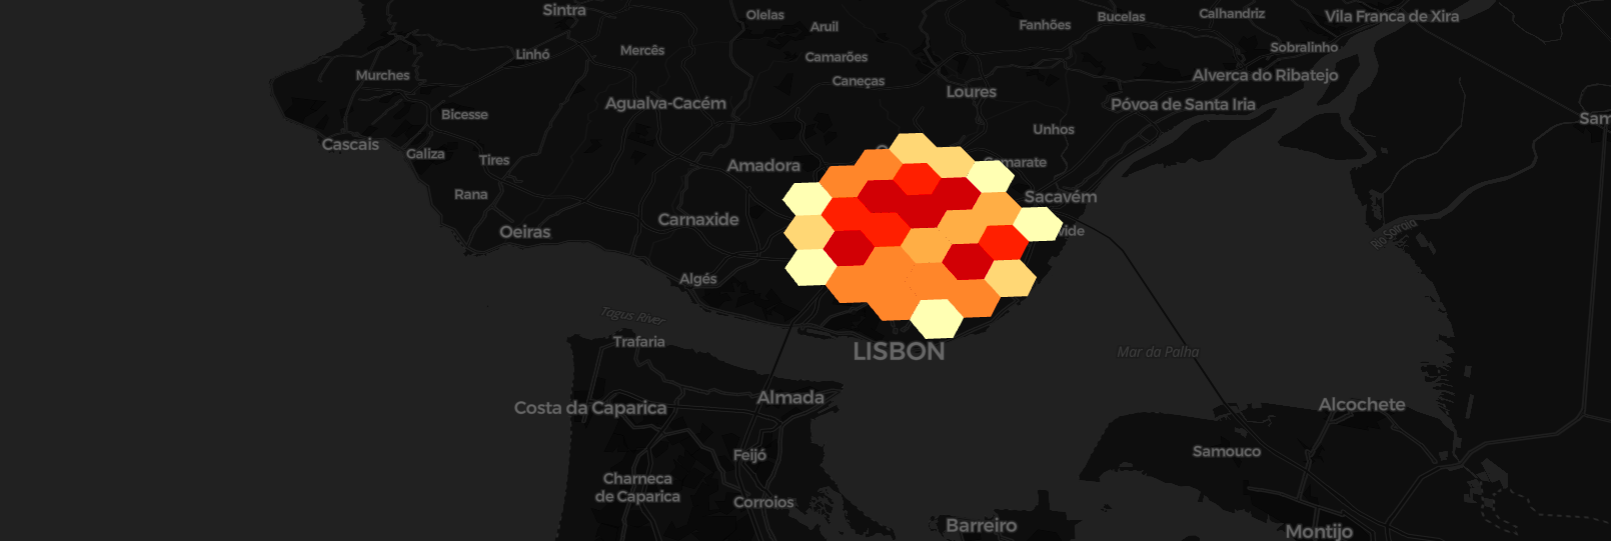

# **6. Further works and disclaimers**

**Final map** does not really reflect the road defects in Lisbon. The reason is that, due to lack of time on our part and lack of computational resources, the model obtained is not really accurate. We decided to proceed with it anyway in order to create a robust pipeline that could be trully used if the model is improved. 

**Regarding the model**:

We have used the YOLOv5s model (the smaller model out of the four they provide) because it is the fastest and we thought the parameters were sufficient for our task. For the resons mentioned before we haven't been able to fine tune it and that is one reason for the low mAP. Also, we are trying to detect on a set of iamges whose categories are not included on those used to train YOLOv5 (our classes are not in the COCO dataset), so an intial low mAP was to be expected.

For further work, we would like to train on the other YOLOv5 models (Yolov5m, Yolov5l, Yolovx) in order to compare accuracies and determine if the increase in mAP (more parameters usually lead to higher accuracy) is substantial in order to justify using more energy in computing said model. Higher use of energy means higher CO2 emissions, so we would like to make sure these emissions are fully justified.


**Regarding the map**:

Always taking into account that the results do not fully reflect reality, we have come to the following conclusions.

